In [7]:
# import torch
# import numpy as np
# import matplotlib.pyplot as plt
# import torch.nn as nn

# torch.manual_seed(42)
# np.random.seed(42)

# N = 30

# # --- 1. DATA GENERATION ---
# # Inputs: We store indices [number_idx, relation_idx] for the Embedding layers
# # Shape: (2*N, 2)
# dataset = np.zeros((2*N, 2), dtype=int)

# # Relation 0 (First N samples)
# for i in range(N):
#     dataset[i][0] = i # The number
#     dataset[i][1] = 0 # Relation 0

# # Relation 1 (Next N samples)
# for i in range(N, 2*N):
#     dataset[i][0] = i - N # The number
#     dataset[i][1] = 1 # Relation 1

# # Labels: First we calculate indices, then convert to ONE-HOT to match your training loop
# labels_indices = np.zeros((2*N), dtype=int)

# for i in range(N):
#     labels_indices[i] = (i + 10) % N # Relation 0 logic

# for i in range(N, 2*N):
#     labels_indices[i] = (i - N + 20) % N # Relation 1 logic

# # Convert targets to ONE-HOT vectors because your train function uses torch.argmax()
# labels_onehot = np.zeros((2*N, N))
# for i in range(2*N):
#     labels_onehot[i][labels_indices[i]] = 1

# # Shuffle
# shuffle = np.random.permutation(2*N)
# dataset = dataset[shuffle]
# labels_onehot = labels_onehot[shuffle]

# # Split
# train_proportion = 0.8
# split_idx = int(train_proportion * 2 * N)

# # Inputs are LongTensor (indices), Labels are FloatTensor (one-hot)
# train_data = torch.LongTensor(dataset[:split_idx])
# train_labels = torch.from_numpy(labels_onehot[:split_idx]).float()
# val_data = torch.LongTensor(dataset[split_idx:])
# val_labels = torch.from_numpy(labels_onehot[split_idx:]).float()


# # --- 2. CORRECTED MODEL (With Embeddings) ---
# class BilinearMLP(nn.Module):
#     def __init__(self, num_entities, dim, output_size):
#         super().__init__()
#         # NEW: Embedding for the numbers (0...29)
#         self.num_embed = nn.Embedding(num_entities, dim)
        
#         # Existing: Embedding for the relations (0, 1)
#         self.rel_embed = nn.Embedding(2, dim)
        
#         # Bilinear Layer
#         self.bl = nn.Bilinear(dim, dim, dim, bias=False)
        
#         # Output Layer
#         self.lin = nn.Linear(dim, output_size, bias=False)
        
#     def forward(self, x):
#         # x is shape (Batch, 2) -> [number_index, relation_index]
        
#         # 1. Get dense vector for the number
#         e_h = self.num_embed(x[:, 0]) 
        
#         # 2. Get dense vector for the relation
#         e_r = self.rel_embed(x[:, 1]) 
        
#         # 3. Interact
#         h = self.bl(e_h, e_r)
        
#         # 4. Predict
#         logits = self.lin(h)
#         return logits

# # --- 3. YOUR ORIGINAL TRAINING LOOP ---
# def train(model, train_data, train_labels, val_data, val_labels, epochs=100, batch_size=16, lr=0.003):
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
#     loss_fn = torch.nn.CrossEntropyLoss()
    
#     train_loss_values = []
#     val_loss_values = []
#     train_acc_values = []
#     val_acc_values = []
    
#     running_train_loss = 0
#     print(epochs)
#     for epoch in range(epochs):
#         model.train()
#         correct_train_preds = 0
#         total_train_preds = 0
#         for batch in range(0, len(train_data), batch_size):
#             optimizer.zero_grad()
#             output = model(train_data[batch:batch+batch_size])
#             # Note: This argmax expects train_labels to be one-hot, which we ensured above
#             loss = loss_fn(output, torch.argmax(train_labels[batch:batch+batch_size], axis=1)) 
#             running_train_loss += loss.item()
#             preds = torch.argmax(output, axis=1)
#             correct_train_preds += (preds == torch.argmax(train_labels[batch:batch+batch_size], axis=1)).sum().item()
#             total_train_preds += len(preds)
#             loss.backward()
#             optimizer.step()
        
#         # Use simple eval if inference_mode causes version issues, but this is standard
#         model.eval()
#         with torch.no_grad(): # Switched to no_grad() as it is more compatible across versions
#             output = model(val_data)
#             val_loss = loss_fn(output, torch.argmax(val_labels, axis=1)).item()
#             val_preds = torch.argmax(output, axis=1)
#             correct_val_preds = (val_preds == torch.argmax(val_labels, axis=1)).sum().item()
#             total_val_preds = len(val_preds)
#             avg_train_loss = running_train_loss / (len(train_data) / batch_size)
#             train_acc = correct_train_preds / total_train_preds
#             val_acc = correct_val_preds / total_val_preds
#             train_loss_values.append(avg_train_loss)
#             val_loss_values.append(val_loss)
#             train_acc_values.append(train_acc)
#             val_acc_values.append(val_acc)

#         if epoch % 50 == 0:
#             print("Epoch: {} | Train loss: {:.2f} | Validation loss: {:.2f} | Train accuracy: {:.2f} | Validation accuracy: {:.2f}".format(epoch, avg_train_loss, val_loss, train_acc, val_acc))

#         running_train_loss = 0
#     return model, train_loss_values, val_loss_values, train_acc_values, val_acc_values


# # --- 4. EXECUTION ---
# # Input dim is N (embedding size), Output is N (classes)
# model = BilinearMLP(num_entities=N, dim=N, output_size=N)

# # Reduced epochs to 500 as embeddings converge much faster than raw one-hots
# model, train_loss_values, val_loss_values, train_acc_values, val_acc_values = train(model, train_data, train_labels, val_data, val_labels, epochs=500, batch_size=16, lr=0.003)

# # Plotting
# plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
# plt.plot(train_loss_values, label='Train Loss')
# plt.plot(val_loss_values, label='Val Loss')
# plt.title('Loss')
# plt.legend()

# plt.subplot(1, 2, 2)
# plt.plot(train_acc_values, label='Train Acc')
# plt.plot(val_acc_values, label='Val Acc')
# plt.title('Accuracy')
# plt.legend()
# plt.show()

Training on cpu...
Epoch     0 | Tr Acc: 0.02 | Val Acc: 0.00 | Weight Norm: 94.36
Epoch  1000 | Tr Acc: 1.00 | Val Acc: 0.00 | Weight Norm: 32.77
Epoch  2000 | Tr Acc: 1.00 | Val Acc: 0.00 | Weight Norm: 32.76
Epoch  3000 | Tr Acc: 1.00 | Val Acc: 0.00 | Weight Norm: 33.34
Epoch  4000 | Tr Acc: 1.00 | Val Acc: 0.00 | Weight Norm: 33.86
Epoch  5000 | Tr Acc: 1.00 | Val Acc: 0.00 | Weight Norm: 34.61
Epoch  6000 | Tr Acc: 1.00 | Val Acc: 0.00 | Weight Norm: 35.31
Epoch  7000 | Tr Acc: 1.00 | Val Acc: 0.00 | Weight Norm: 36.01
Epoch  8000 | Tr Acc: 1.00 | Val Acc: 0.00 | Weight Norm: 36.58
Epoch  9000 | Tr Acc: 1.00 | Val Acc: 0.00 | Weight Norm: 36.97
Epoch 10000 | Tr Acc: 1.00 | Val Acc: 0.00 | Weight Norm: 37.40
Epoch 11000 | Tr Acc: 1.00 | Val Acc: 0.00 | Weight Norm: 37.88
Epoch 12000 | Tr Acc: 1.00 | Val Acc: 0.00 | Weight Norm: 38.29
Epoch 13000 | Tr Acc: 1.00 | Val Acc: 0.00 | Weight Norm: 38.67
Epoch 14000 | Tr Acc: 1.00 | Val Acc: 0.00 | Weight Norm: 38.87
Epoch 15000 | Tr Acc:

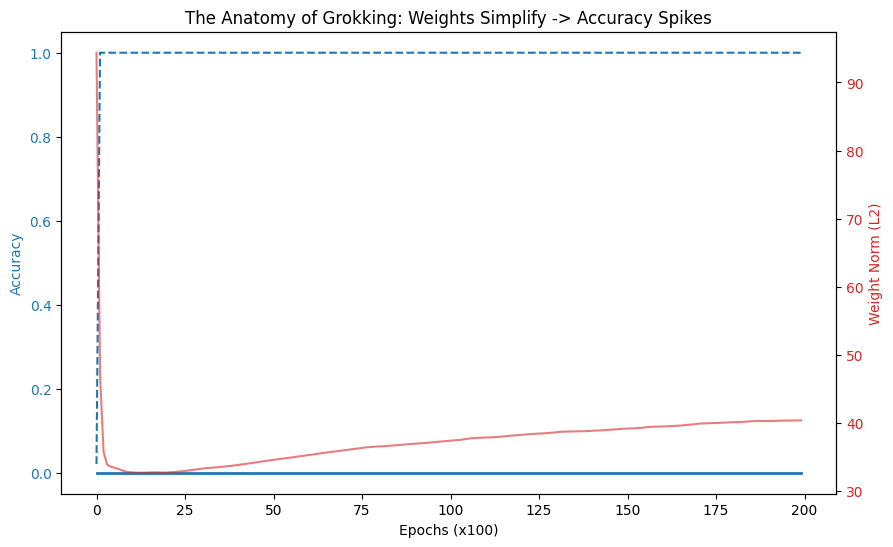

In [8]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt

# Reproducibility
torch.manual_seed(42)
np.random.seed(42)

# --- 1. Dataset (Unchanged) ---
N = 30 # Small prime numbers like 53 or 97 usually grok cleaner, but 30 works too.
dataset = np.zeros((2*N, N+1)) 

for i in range(N):
    dataset[i][N] = 0
    dataset[i][i] = 1
for i in range(N, 2*N):
    dataset[i][N] = 1
    dataset[i][i-N] = 1
            
labels = np.zeros((2*N, N))
for i in range(N):
    labels[i][(i+10)%N] = 1
for i in range(N, 2*N):
    labels[i][(i-N+20)%N] = 1

# Shuffle
p = np.random.permutation(2*N)
dataset = dataset[p]
labels = labels[p]

# Split
train_proportion = 0.8
limit = int(train_proportion * 2 * N)

# Move to GPU if available (Grokking is faster on GPU)
device = "cuda" if torch.cuda.is_available() else "cpu"

train_x = torch.from_numpy(dataset[:limit]).float().to(device)
train_y = torch.argmax(torch.from_numpy(labels[:limit]), dim=1).to(device)
val_x = torch.from_numpy(dataset[limit:]).float().to(device)
val_y = torch.argmax(torch.from_numpy(labels[limit:]), dim=1).to(device)

# --- 2. The "Grokking" Architecture ---
class TransformerStyleMLP(nn.Module):
    def __init__(self, num_entities, hidden_dim):
        super().__init__()
        # Embeddings
        self.emb_x = nn.Embedding(num_entities, hidden_dim)
        self.emb_r = nn.Embedding(2, hidden_dim)
        
        # Simple MLP
        self.mlp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4), # Wide hidden layer
            nn.ReLU(),
            nn.Linear(hidden_dim * 4, num_entities)
        )

    def forward(self, x_raw):
        # Parse inputs
        x_idx = torch.argmax(x_raw[:, :N], dim=1).long()
        r_idx = x_raw[:, N].long()
        
        # ADD embeddings. This forces a shared geometric structure.
        # This is the key change from Bilinear.
        h = self.emb_x(x_idx) + self.emb_r(r_idx)
        
        logits = self.mlp(h)
        return logits

# --- 3. Training Setup ---
model = TransformerStyleMLP(num_entities=N, hidden_dim=128).to(device)
# ... (Previous model and dataset code remains the same) ...

# --- TUNED TRAINING SETUP ---
# 1. Increased Weight Decay to force the "simplification" faster
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=10.0) 
loss_fn = nn.CrossEntropyLoss()

epochs = 20000  # Grokking takes time!
train_accs = []
val_accs = []
weight_norms = [] # NEW: Metric to predict when Grokking will happen

print(f"Training on {device}...")

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    
    logits = model(train_x)
    loss = loss_fn(logits, train_y)
    
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        model.eval()
        with torch.no_grad():
            tr_preds = torch.argmax(logits, dim=1)
            tr_acc = (tr_preds == train_y).float().mean().item()
            
            val_logits = model(val_x)
            val_preds = torch.argmax(val_logits, dim=1)
            val_acc = (val_preds == val_y).float().mean().item()
            
            # Calculate L2 Norm of all weights (The "Complexity" of the model)
            l2_norm = sum(p.norm().item() for p in model.parameters())
            
            train_accs.append(tr_acc)
            val_accs.append(val_acc)
            weight_norms.append(l2_norm)
            
            if epoch % 1000 == 0:
                print(f"Epoch {epoch:5d} | Tr Acc: {tr_acc:.2f} | Val Acc: {val_acc:.2f} | Weight Norm: {l2_norm:.2f}")

# --- VISUALIZATION ---
fig, ax1 = plt.subplots(figsize=(10, 6))

ax1.set_xlabel('Epochs (x100)')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.plot(train_accs, label="Train Acc", color='tab:blue', linestyle='--')
ax1.plot(val_accs, label="Val Acc", color='tab:blue', linewidth=2)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Plot Weight Norm on a secondary axis
ax2 = ax1.twinx()  
ax2.set_ylabel('Weight Norm (L2)', color='tab:red')
ax2.plot(weight_norms, label="Weight Norm", color='tab:red', alpha=0.6)
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("The Anatomy of Grokking: Weights Simplify -> Accuracy Spikes")
plt.show()